In [1]:
# Import needed libraries
import torch  # install via command provided in https://pytorch.org/get-started/locally/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# read clean data + plz data
data = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv"
)
data = data[["price", "zip_code", "living_space", "rooms", "type"]]
plz = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/plz_data.csv"
)


In [3]:
# print all object types (this will be the categories in our y)
data["type"].unique()


array(['penthouse', 'terrace-house', 'detached-house', 'flat',
       'stepped-house', 'farmhouse', 'semi-detached-house',
       'stepped-apartment', 'duplex-maisonette', 'attic-flat', 'loft',
       'chalet', 'villa', 'attic-room', 'secondary-suite', 'castle',
       'detached-secondary-suite', 'studio',
       'furnished-residential-property', 'rustico', 'single-room'],
      dtype=object)

In [4]:
# join clean data with plz data on plz
data = pd.get_dummies(data, columns=["type"])
data = data.merge(plz, how="inner", left_on="zip_code", right_on="PLZ")
data = data.drop(columns=["PLZ", "zip_code"])

# print number of observations + data preview
print(len(data))
data


13069


,price,living_space,rooms,type_attic-flat,type_attic-room,type_castle,type_chalet,type_detached-house,type_detached-secondary-suite,type_duplex-maisonette,...,PLZ_Group_9000,PLZ_Group_9100,PLZ_Group_9200,PLZ_Group_9300,PLZ_Group_9400,PLZ_Group_9500,PLZ_Group_9600,PLZ_Group_9700,PLZ_Group_9800,PLZ_Group_9900
0,1150000.0,100.0,3.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1420000.0,156.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1430000.0,154.0,4.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,550000.0,124.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,720000.0,93.0,2.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13064,895000.0,130.0,4.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13065,1090000.0,147.0,5.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13066,2750000.0,385.0,7.5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13067,1415000.0,150.0,6.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# check how many NA in every column
data.isna().sum().sort_values(ascending=False)


living_space                         1069
price                                1025
rooms                                 582
PLZ_Group_9800                          0
PLZ_Group_4100                          0
                                     ... 
NoisePollutionRailwayL                  0
gde_politics_fdp                        0
gde_social_help_quota                   0
gde_area_nonproductive_percentage       0
PLZ_Group_9900                          0
Length: 162, dtype: int64

In [6]:
# drop NAs
data = data.dropna()
# print new number of observations
len(data)


10923

In [7]:
# define columns for X and y
y_cols = data.columns[data.columns.str.startswith("type_")]
X_cols = list(set(data._get_numeric_data().columns) - set(y_cols))

# convert pandas data to numpy arrays
X = data[X_cols].values
y = data[y_cols].values


In [8]:
# scale data to whole dataset
scaler = StandardScaler().fit(X)
X = scaler.transform(X)


In [9]:
# split train and val data (70%/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=420)


In [10]:
# create tensors from numpy arrays
X_train = torch.from_numpy(X_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))


In [11]:
# define model architecture
class Gabonisator(torch.nn.Module):
    # run super and define layers
    def __init__(self, n_features, n_outputs):
        super(Gabonisator, self).__init__()
        # define first hidden layer | input -> 64 nodes
        self.hidden1 = torch.nn.Linear(n_features, 64)
        # define second hidden layer | 64 nodes -> 64 nodes
        self.hidden2 = torch.nn.Linear(64, 64)
        # define output layer | 64 nodes -> output
        self.output = torch.nn.Linear(64, n_outputs)

    # define forward prop
    def forward(self, X):
        # first hidden layer + relu activation function
        y_pred = self.hidden1(X)
        y_pred = torch.relu(y_pred)
        # second hidden layer + relu activation function
        y_pred = self.hidden2(y_pred)
        y_pred = torch.relu(y_pred)
        # output layer + softmax to normalize results
        y_pred = self.output(y_pred)
        y_pred = torch.softmax(y_pred, dim=1)
        # return calculated y values
        return y_pred


In [12]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train)
    # loss function
    loss_train = lossf(y_pred, y_train)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
    )
    print(
        f"   Best val loss: {np.min(loss_val_arr):.4f} at Epoch {np.argmin(loss_val_arr) + 1}"
    )


Epoch:   500/10000 | Loss train: 0.1601 | Loss val: 0.1601
Epoch:  1000/10000 | Loss train: 0.1185 | Loss val: 0.1191
Epoch:  1500/10000 | Loss train: 0.1083 | Loss val: 0.1099
Epoch:  2000/10000 | Loss train: 0.1013 | Loss val: 0.1041
Epoch:  2500/10000 | Loss train: 0.0955 | Loss val: 0.0995
Epoch:  3000/10000 | Loss train: 0.0915 | Loss val: 0.0968
Epoch:  3500/10000 | Loss train: 0.0885 | Loss val: 0.0954
Epoch:  4000/10000 | Loss train: 0.0859 | Loss val: 0.0947
Epoch:  4500/10000 | Loss train: 0.0836 | Loss val: 0.0944
Epoch:  5000/10000 | Loss train: 0.0815 | Loss val: 0.0945
Epoch:  5500/10000 | Loss train: 0.0795 | Loss val: 0.0948
Epoch:  6000/10000 | Loss train: 0.0775 | Loss val: 0.0953
Epoch:  6500/10000 | Loss train: 0.0755 | Loss val: 0.0962
Epoch:  7000/10000 | Loss train: 0.0736 | Loss val: 0.0974
Epoch:  7500/10000 | Loss train: 0.0717 | Loss val: 0.0988
Epoch:  8000/10000 | Loss train: 0.0698 | Loss val: 0.1004
Epoch:  8500/10000 | Loss train: 0.0680 | Loss val: 0.10

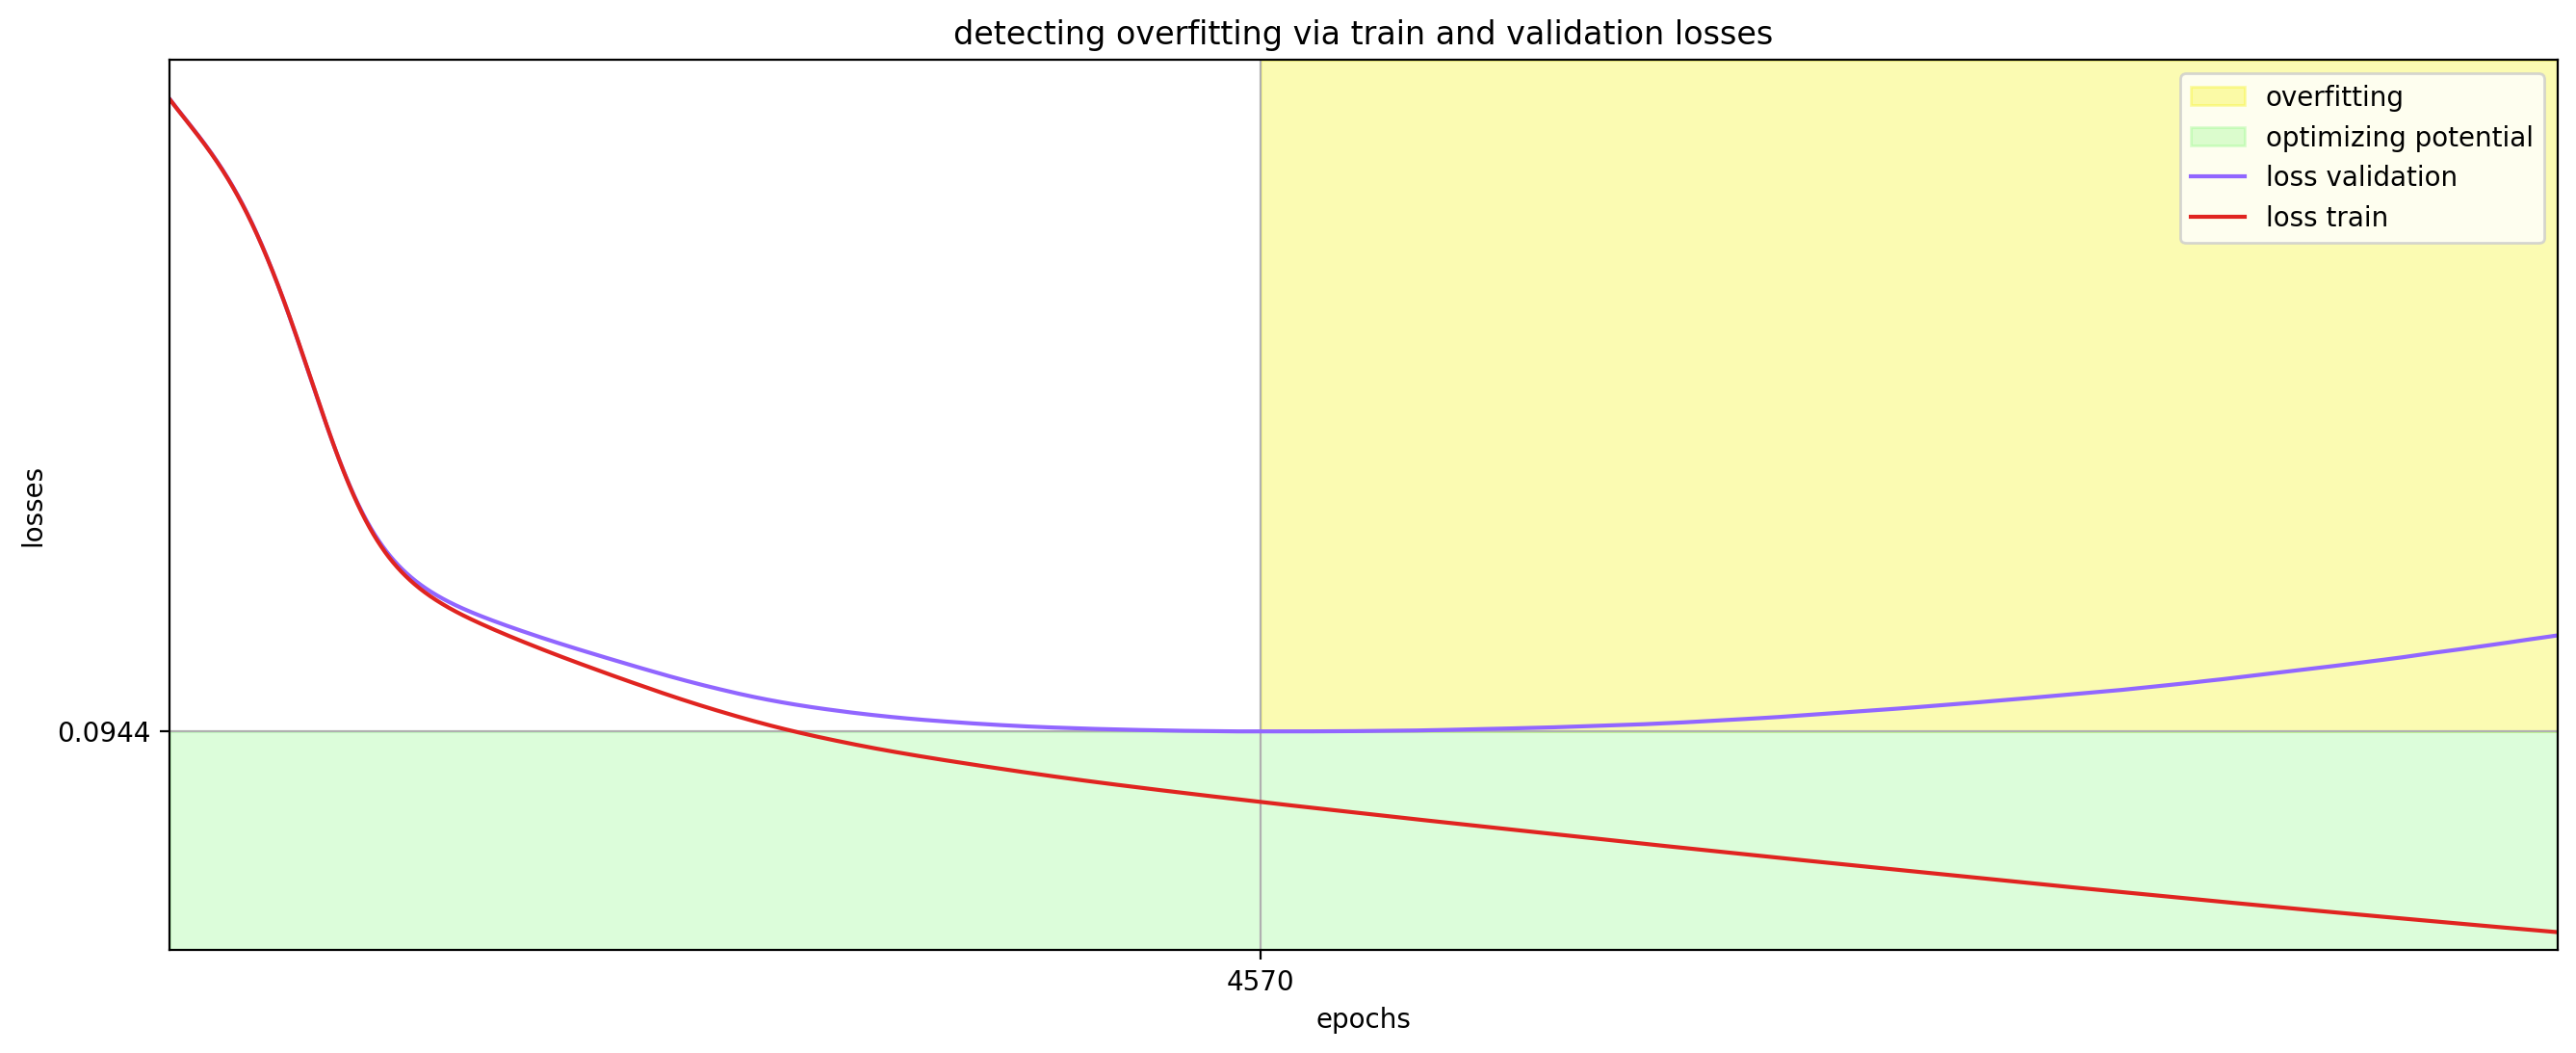

In [13]:
# visualize score
ymin = 0.06
ymax = 0.20
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()


Die Architektur unseres neuronalen Netzes sieht so aus:

<svg xmlns="http://www.w3.org/2000/svg" style="cursor: move; background: white;" width="380" height="185"><g transform="translate(-743.5554710569938,-326.8616196843533)scale(1.1)"><polygon class="poly" id="fc_0" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="718.5,344.6489719263484 728.5,344.6489719263484 828.2020561473032,444.3510280736516 818.2020561473032,444.3510280736516"></polygon><polygon class="poly" id="fc_1" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="830.2020561473032,371.87258300203047 840.2020561473032,371.87258300203047 885.4568901432423,417.1274169979695 875.4568901432423,417.1274169979695"></polygon><polygon class="poly" id="fc_2" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="887.4568901432422,371.87258300203047 897.4568901432422,371.87258300203047 942.7117241391812,417.1274169979695 932.7117241391812,417.1274169979695"></polygon><polygon class="poly" id="fc_3" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="944.7117241391812,387.07537879754125 954.7117241391812,387.07537879754125 969.5609665440987,401.92462120245875 959.5609665440987,401.92462120245875"></polygon><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="818.2020561473032" y2="444.3510280736516"></line><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="718.5" y2="344.6489719263484"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="828.2020561473032" y1="444.3510280736516" x2="875.4568901432422" y2="417.1274169979695"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="728.5" y1="344.6489719263484" x2="830.2020561473032" y2="371.87258300203047"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="885.4568901432422" y1="417.1274169979695" x2="932.7117241391812" y2="417.1274169979695"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="840.2020561473032" y1="371.87258300203047" x2="887.4568901432422" y2="371.87258300203047"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="942.7117241391812" y1="417.1274169979695" x2="959.5609665440987" y2="401.92462120245875"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="897.4568901432422" y1="371.87258300203047" x2="944.7117241391812" y2="387.07537879754125"></line><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="718.5" y="329.6489719263484">1x141</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="830.2020561473032" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="887.4568901432422" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="944.7117241391812" y="372.07537879754125">1x21</text></g></svg>

In [14]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train)
    # loss function
    loss_train = lossf(y_pred, y_train)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # loss val goes up too much -> EarlyStop
    if np.round(np.min(loss_val_arr), 4) != np.round(loss_val.item(), 4):
        print("Early Stopping!")
        break

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    score = (
        (model(X_val).argmax(axis=1) == y_val.argmax(axis=1)).sum() / y_val.shape[0]
    ).item()
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f} | Score: {score:.4f}"
    )

Epoch:   500/10000 | Loss train: 0.1596 | Loss val: 0.1590
Epoch:  1000/10000 | Loss train: 0.1157 | Loss val: 0.1160
Epoch:  1500/10000 | Loss train: 0.1057 | Loss val: 0.1076
Epoch:  2000/10000 | Loss train: 0.0993 | Loss val: 0.1023
Epoch:  2500/10000 | Loss train: 0.0944 | Loss val: 0.0987
Epoch:  3000/10000 | Loss train: 0.0909 | Loss val: 0.0967
Epoch:  3500/10000 | Loss train: 0.0881 | Loss val: 0.0956
Epoch:  4000/10000 | Loss train: 0.0858 | Loss val: 0.0951
Epoch:  4500/10000 | Loss train: 0.0837 | Loss val: 0.0950
Early Stopping!
---
Final Run
Epoch:  4809/10000 | Loss train: 0.0824 | Loss val: 0.0951 | Score: 0.6314


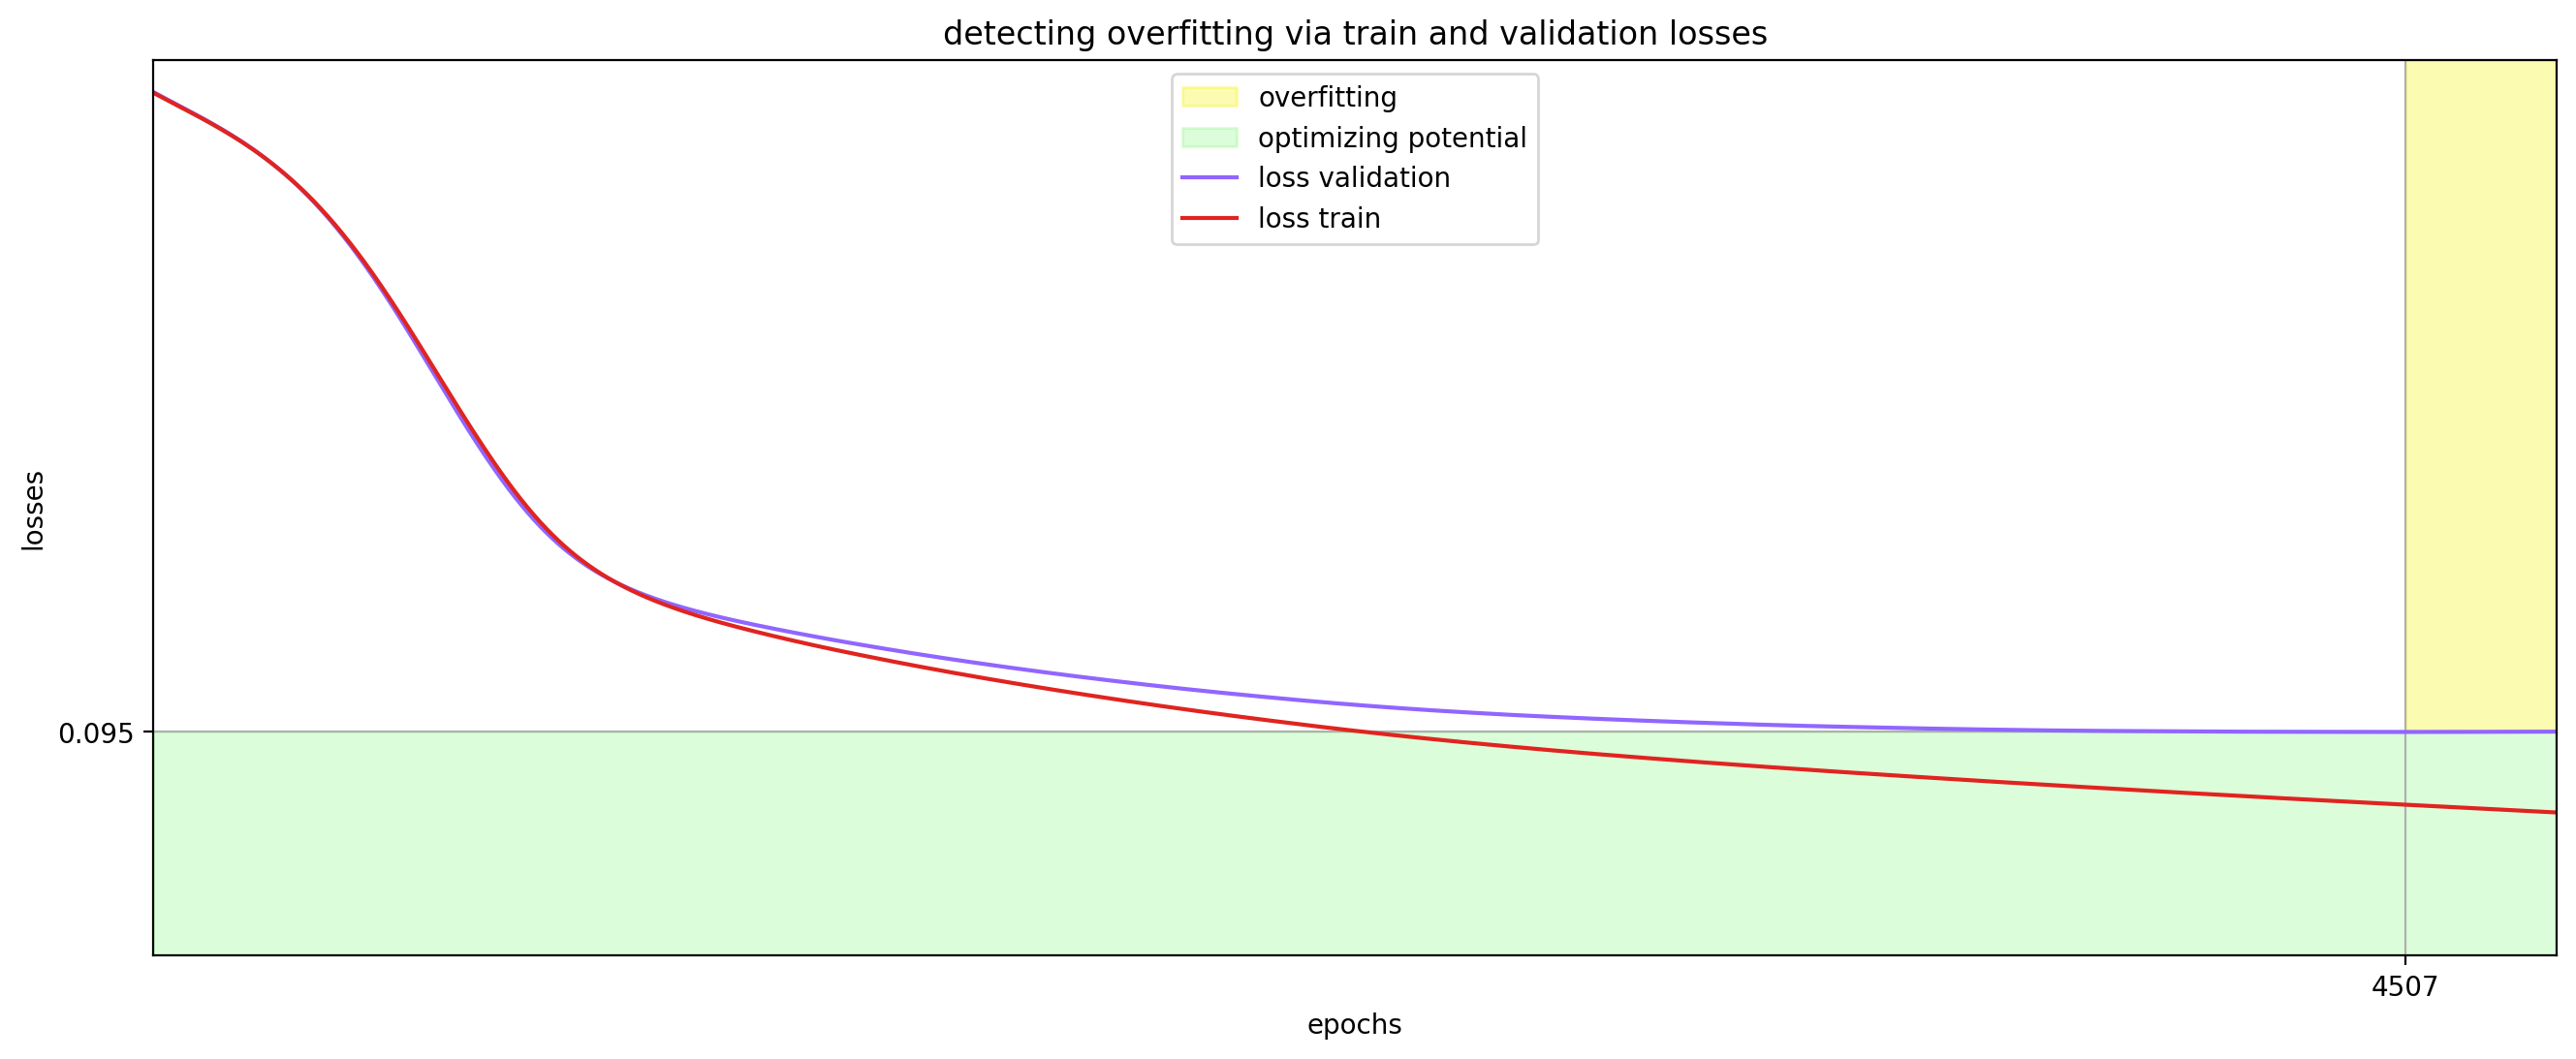

In [15]:
# visualize score
ymin = 0.06
ymax = 0.20
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()
